# Iteración:  Modelo de aprendizaje supervisado

Para esta iteración se utlizan los datos relacionados a eventos de hurto en la ciudad de medellín y se busca predecir la cantidad de eventos utilizando redes neuronales como modelo de aprendizaje supervisado.

## Datos y preprocesamiento

La temporalidad de los datos es diria para los años 2015 a 2018

In [1442]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sbn
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam
sbn.set(rc={'figure.figsize':(10, 5)})

In [1440]:
#carga de datos
datos = pd.read_excel('/home/david/Descargas/Delitos-2003-2018/Hurto.xlsx')
# filtro necesario
datos = datos[datos['Caso Hurto'] == 1]
datos.columns

Index(['Caso Hurto', 'Día', 'Hora Hurto', 'Minuto Hurto',
       'Nombre Bien Sijin Hurto', 'Grupo Bien', 'Conducta Especial',
       'Conducta', 'Modalidad', 'Sexo', 'Edad Hurto', 'Cod. Barrio', 'Barrio',
       'Cod. Comuna', 'Comuna', 'Plana X Hurto', 'Plana Y Hurto',
       'Geo X Hurto', 'Geo Y Hurto', 'Modelo Hurto', 'Linea Marca Hurto',
       'Estado Civil', 'Medio Transporte', 'Medio Transporte Agresor', 'Marca',
       'Arma Medio'],
      dtype='object')

In [1454]:
# filtro años 
datos['ano']=datos['Día'].dt.year
df = datos[datos['ano'] > 2015]

# Modelo univariado
### Obtener conteo por día
Se obtiene el conteo por día en donde la fecha corresponde al index del dataframe


In [1455]:
## Extracción
def group_column(data, name, group=None, func='count'):
	"""
	función para hacer agregaciones a un dataframe
	:param data: dataframe
	:param name:  string, nombre para la nueva columna
	:param group: lista o string, nombre de las columnas para agrupar
	:param func: string o numpy ej: np.sum, funcion de agregacion
	:return:
	"""
	default=['Día']
	if group:
		if type(group) == list:
			default.extend(group)
		else:
			default.append(group)
	temp = data.groupby(default).agg({'Caso Hurto': func})
	temp.columns = [name]
	df = temp.reset_index()
	df = pd.merge(data, df, how='left', on=default)
	return df, temp
df = group_column(df,'cuenta_dia')[1]
df.describe()


,cuenta_dia
count,1096.000000
mean,78.271898
std,25.188513
min,12.000000
25%,60.000000
50%,76.000000
75%,97.000000
max,182.000000


Periodo temporal tomado para el ejercicio

In [1456]:
print(df.index.min())
print(df.index.max())

2016-01-01 00:00:00
2018-12-31 00:00:00


### Transformación seríes de tiempo a formato supervisado

In [1488]:
PASOS=14
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()



,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
14,-0.752941,-0.705882,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000
15,-0.705882,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882
16,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000
17,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,-0.647059
18,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,-0.647059,-0.670588


### División del conjunto de datos

In [1489]:

values = reframed.values
n_train_days = len(reframed) - int(len(reframed)*0.2)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(866, 1, 14) (866,) (216, 1, 14) (216,)


# Modelo

Arquitectura de la Red neuronal

Ejemplo de red neuronal
<img src="Red-neuronal-artificial.png">


Perceptrón de una capa
El tipo más sencillo de red neuronal es el perceptrón de una capa, el cual consta de una sola capa de nodos de salida; las entradas están conectadas directamente a las salidas a través de una serie de ponderaciones. Es por esto que puede ser considerada el tipo más sencillo de red prealimentada. La suma de los productos de las ponderaciones y las entradas es calculada en cada nodo y, si el valor es superior a algún umbral (típicamente 0), los neurona es disparada y toma el valor de activación (típicamente 1); de forma contraria, toma el valor de desactivación (típicamente -1). Las neuronas con esta clase de función de activación son también llamadas neuronas artificiales o unidades de umbral lineal. Muchos autores usan el término perceptrón para las redes que constan de únicamente una de estas unidades.
https://es.wikipedia.org/wiki/Red_neuronal_prealimentada


### Capa entrada
30 neuronas correspondiente a la cantidad de inputs
### Capas ocultas
1 capa oculta con 30 neuronas 
### capa de salidad
La salida será 1 sola neurona
### Función de activación
Se utiliza tangente hiperbólica puesto que utilizaremos valores entre -1 y 1.

Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error
Como la predicción será un valor continuo y no discreto, para calcular el Acuracy utilizaremos Mean Squared Error y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

### Referencia función de costo en redes neuronales:
http://www.diegocalvo.es/funcion-de-coste-redes-neuronales/

Adam
El optimizador Adam trata de solventar el problema con la fijación de el ratio de aprendizaje del SGD (Stochastic Gradient Descent), para ello adapta el ratio de aprendizaje en función de cómo estén distribuidos los parámetros. Si los parámetros están muy dispersos (sparse) el ratio de aprendizaje aumentará.

Adam es una actualización del Optimizador RMSProp (Root Mean Square Propagation) que se basa en un ratio de aprendizaje adaptativa.

### Flatten
se realiza para convertir los datos multidimensionales en un vector de características 1D para ser utilizado por la siguiente capa que es la capa densa

### Dropout
Técnica de regularización para reducir el sobreajuste en redes neuronales al evitar complejas adaptaciones en los datos de entrenamiento. Es una forma muy eficiente de realizar promedios de modelos con redes neuronales convolucionales (CNN). El término “abandono” se refiere al abandono de unidades (tanto ocultas como visibles) en redes neuronales.
http://sitiobigdata.com/2018/08/28/redes-neuronales-convolucionales-vista-rapida-implementacion/

In [1490]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=["mse"])
    model.summary()
    return model

# Iteraciones
EPOCHS = 64

model = crear_modeloFF()

#Entrenamiento
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=PASOS)

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_289 (Dense)            (None, 1, 14)             210       
_________________________________________________________________
dropout_84 (Dropout)         (None, 1, 14)             0         
_________________________________________________________________
flatten_145 (Flatten)        (None, 14)                0         
_________________________________________________________________
dense_290 (Dense)            (None, 1)                 15        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
Train on 866 samples, validate on 216 samples
Epoch 1/64
866/866 [==============================] - 0s 253us/step - loss: 0.3946 - mse: 0.2323 - val_loss: 0.3330 - val_mse: 0.1626
Epoch 2/64
866/866 [==============================] - 0s 78us/step - loss

## Comparamos resultados de entrenamiento y validación

In [1491]:
#loss: 0.1084 - mse: 0.0198 - val_loss: 0.1482 - val_mse: 0.0382 dropau  0.7 n=30  2010
#loss: 0.1841 - mse: 0.0620 - val_loss: 0.1959 - val_mse: 0.0666

results=model.predict(x_val)

compara = pd.DataFrame([y_val, [x[0] for x in results]]).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
# difrencia máxima y mínima
print(compara2.diferencia.min())
print(compara2.diferencia.max())

compara2.head(7)

-70.13434827996296
70.76273638194664


,real,prediccion,diferencia
0,94.999998,102.081216,-7.081219
1,132.000000,108.293157,23.706843
2,118.000001,118.378805,-0.378804
3,131.000005,89.276375,41.723630
4,50.000001,78.466827,-28.466826
5,59.000000,89.851207,-30.851207
6,94.999998,86.329190,8.670808


In [1492]:
compara2.describe()

,real,prediccion,diferencia
count,216.000000,216.000000,216.000000
mean,99.893518,96.365285,3.528233
std,23.853677,14.364854,19.273565
min,29.999998,61.437765,-70.134348
25%,86.000003,87.322434,-8.726840
50%,102.999997,98.296757,3.324227
75%,112.999996,107.166739,14.468065
max,181.999996,132.056870,70.762736


In [1493]:
## Plot real vs pronosticos

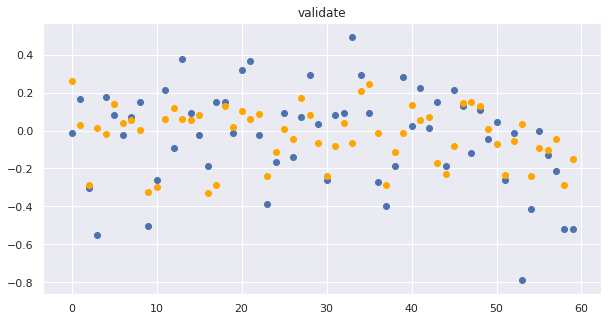

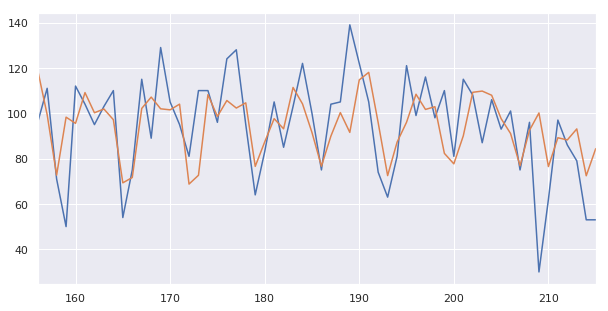

In [1494]:
window = 60
plt.scatter(range(len(y_val[-window:])),y_val[-window:],c='b')
plt.scatter(range(len(results[-window:])),results[-window:],c='orange')
plt.title('validate')
plt.show()
compara2['real'][len(compara2)-window:].plot()
compara2['prediccion'][len(compara2)-window:].plot()

# narajando prediccion, azul valores reales

## Plot función de perdida

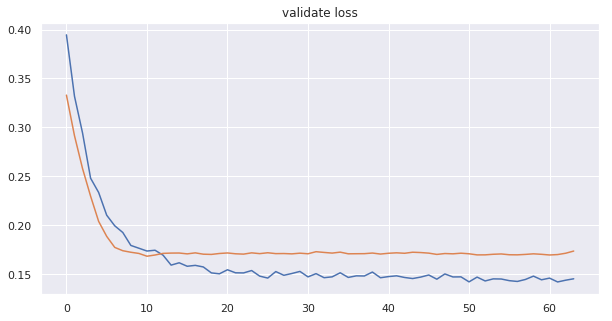

In [1495]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

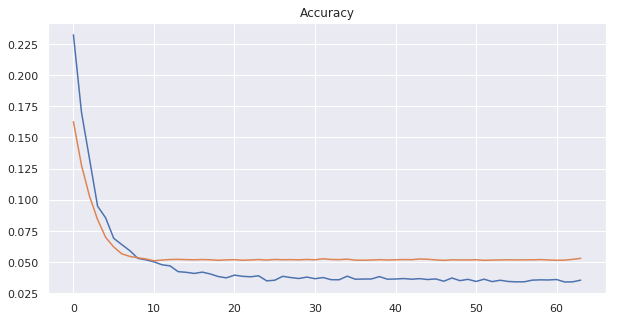

In [1496]:
#plt.ylim(0.01, 0.08)
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.show()

## Multivariado

In [1497]:
df = datos
df['ano']=df['Día'].dt.year
df = df[df['ano'] > 2016]

In [1498]:
## Extracción
def group_column(data, name, group=None, func='count'):
	"""
	función para hacer agregaciones a un dataframe
	:param data: dataframe
	:param name:  string, nombre para la nueva columna
	:param group: lista o string, nombre de las columnas para agrupar
	:param func: string o numpy ej: np.sum, funcion de agregacion
	:return:
	"""
	default=['Día']
	if group:
		if type(group) == list:
			default.extend(group)
		else:
			default.append(group)
	temp = data.groupby(default).agg({'Caso Hurto': func})
	temp.columns = [name]
	df = temp.reset_index()
	df = pd.merge(data, df, how='left', on=default)
	return df, temp
df = group_column(df,'cuenta_dia')[1]
df.describe()

,cuenta_dia
count,730.000000
mean,87.205479
std,23.952662
min,27.000000
25%,71.000000
50%,89.000000
75%,104.000000
max,182.000000


In [1499]:
# extracción caracterisiticas de fecha
df['dia']=[x.weekday() for x in df.index]
df['mes']=[x.month for x in df.index]
df['dia_sem']=[x.day for x in df.index]
#df['year']=[x.year for x in df.index]

In [1500]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [1501]:
PASOS=30
values = df['cuenta_dia'].values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('cuenta_dia',axis=1)

reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-30),var2(t-30),var3(t-30),var4(t-30),var1(t-29),var2(t-29),var3(t-29),var4(t-29),var1(t-28),var2(t-28),...,var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
Día,,,,,,,,,,,,,,,,,,,,,
2017-01-31,6.0,1.0,1.0,-0.806452,0.0,1.0,2.0,-0.470968,1.0,1.0,...,29.0,-0.625807,0.0,1.0,30.0,-0.393548,1,1,31,-0.483871
2017-02-01,0.0,1.0,2.0,-0.470968,1.0,1.0,3.0,-0.561290,2.0,1.0,...,30.0,-0.393548,1.0,1.0,31.0,-0.483871,2,2,1,-0.290323
2017-02-02,1.0,1.0,3.0,-0.561290,2.0,1.0,4.0,-0.380645,3.0,1.0,...,31.0,-0.483871,2.0,2.0,1.0,-0.290323,3,2,2,-0.200000
2017-02-03,2.0,1.0,4.0,-0.380645,3.0,1.0,5.0,-0.587097,4.0,1.0,...,1.0,-0.290323,3.0,2.0,2.0,-0.200000,4,2,3,-0.548387
2017-02-04,3.0,1.0,5.0,-0.587097,4.0,1.0,6.0,-0.329032,5.0,1.0,...,2.0,-0.200000,4.0,2.0,3.0,-0.548387,5,2,4,-0.587097


In [1502]:
newReframed=reframed.drop(['var1(t)','var2(t)', 'var3(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(700, 121)


,var1(t-30),var2(t-30),var3(t-30),var4(t-30),var1(t-29),var2(t-29),var3(t-29),var4(t-29),var1(t-28),var2(t-28),...,var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
Día,,,,,,,,,,,,,,,,,,,,,
2017-01-31,6.0,1.0,1.0,-0.806452,0.0,1.0,2.0,-0.470968,1.0,1.0,...,-0.419355,6.0,1.0,29.0,-0.625807,0.0,1.0,30.0,-0.393548,-0.483871
2017-02-01,0.0,1.0,2.0,-0.470968,1.0,1.0,3.0,-0.561290,2.0,1.0,...,-0.625807,0.0,1.0,30.0,-0.393548,1.0,1.0,31.0,-0.483871,-0.290323
2017-02-02,1.0,1.0,3.0,-0.561290,2.0,1.0,4.0,-0.380645,3.0,1.0,...,-0.393548,1.0,1.0,31.0,-0.483871,2.0,2.0,1.0,-0.290323,-0.200000
2017-02-03,2.0,1.0,4.0,-0.380645,3.0,1.0,5.0,-0.587097,4.0,1.0,...,-0.483871,2.0,2.0,1.0,-0.290323,3.0,2.0,2.0,-0.200000,-0.548387
2017-02-04,3.0,1.0,5.0,-0.587097,4.0,1.0,6.0,-0.329032,5.0,1.0,...,-0.290323,3.0,2.0,2.0,-0.200000,4.0,2.0,3.0,-0.548387,-0.587097


In [1503]:
# split into train and test sets
values = newReframed.values
n_train_days = int(len(newReframed)*.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(560, 1, 120) (560,) (140, 1, 120) (140,)


In [1504]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,x_train.shape[2]),activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [1505]:
EPOCHS=124
model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_291 (Dense)            (None, 1, 30)             3630      
_________________________________________________________________
dropout_85 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
flatten_146 (Flatten)        (None, 30)                0         
_________________________________________________________________
dense_292 (Dense)            (None, 1)                 31        
Total params: 3,661
Trainable params: 3,661
Non-trainable params: 0
_________________________________________________________________
Train on 560 samples, validate on 140 samples
Epoch 1/124
560/560 [==============================] - 0s 297us/step - loss: 0.5697 - mse: 0.4667 - val_loss: 0.6492 - val_mse: 0.5270
Epoch 2/124
560/560 [==============================] - 0s 59us/step 

In [1506]:
#loss: 0.1286 - mse: 0.0298 - val_loss: 0.1728 - val_mse: 0.0531   drop 0.15 pasos 30 2015
results=model.predict(x_val)

compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,98.000000,100.990484,-2.990484
1,134.000004,129.731258,4.268746
2,102.999996,116.218030,-13.218034
3,126.000002,116.124598,9.875404
4,106.000002,121.794591,-15.794589
5,57.000002,62.335326,-5.335324
6,57.000002,105.521202,-48.521200
7,101.999997,105.067816,-3.067819
8,102.999996,116.532045,-13.532049
9,119.999998,105.390816,14.609182


In [1507]:
compara2.describe()

,real,prediccion,diferencia
count,140.000000,140.000000,140.000000
mean,99.378571,99.198954,0.179617
std,22.834238,16.712863,17.525796
min,30.000000,56.331622,-74.658838
25%,86.750002,91.496992,-9.745006
50%,103.500000,103.917821,0.428788
75%,111.999997,110.853612,12.262410
max,157.000001,129.731258,45.482480


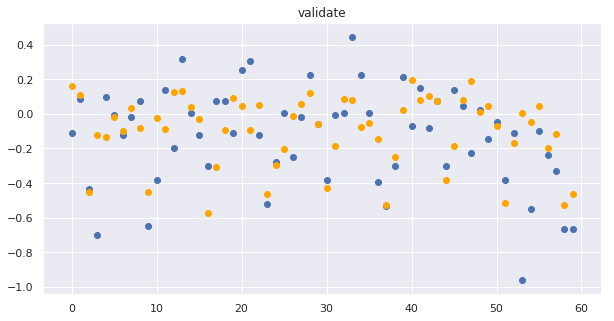

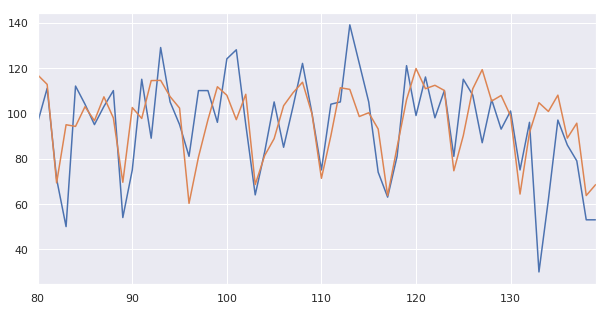

In [1508]:
results=model.predict(x_val)
window = 60
plt.scatter(range(len(y_val[-window:])),y_val[-window:],c='b')
plt.scatter(range(len(results[-window:])),results[-window:],c='orange')
plt.title('validate')
plt.show()
compara2['real'][len(compara2)-window:].plot()
compara2['prediccion'][len(compara2)-window:].plot()

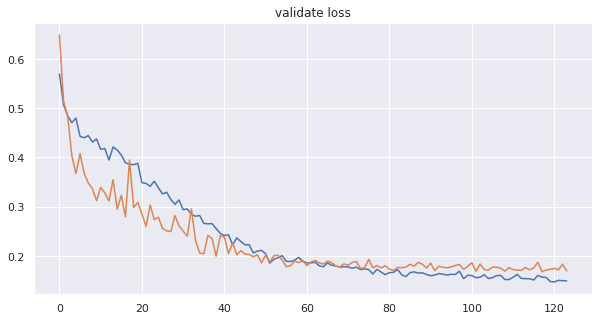

In [1509]:
#plt.ylim(5, 30)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

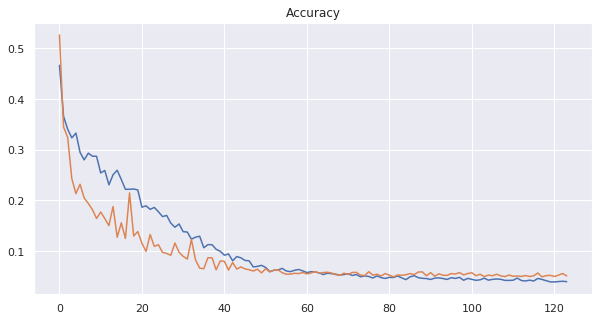

In [1510]:
#plt.ylim(150, 1000)
plt.title('Accuracy')
plt.plot(history.history['mse'])

plt.plot(history.history['val_mse'])
plt.show()

# Embeddings

In [1511]:
df = datos
df['ano']=df['Día'].dt.year
df = df[df['ano'] > 2015]
#df = df[df['ano'] < 2018]

## Extracción
def group_column(data, name, group=None, func='count'):
	"""
	función para hacer agregaciones a un dataframe
	:param data: dataframe
	:param name:  string, nombre para la nueva columna
	:param group: lista o string, nombre de las columnas para agrupar
	:param func: string o numpy ej: np.sum, funcion de agregacion
	:return:
	"""
	default=['Día']
	if group:
		if type(group) == list:
			default.extend(group)
		else:
			default.append(group)
	temp = data.groupby(default).agg({'Caso Hurto': func})
	temp.columns = [name]
	df = temp.reset_index()
	df = pd.merge(data, df, how='left', on=default)
	return df, temp
df = group_column(df,'cuenta_dia')[1]
df.describe()

,cuenta_dia
count,1096.000000
mean,78.271898
std,25.188513
min,12.000000
25%,60.000000
50%,76.000000
75%,97.000000
max,182.000000


In [1512]:
df['dia']=[x.weekday() for x in df.index]
df['mes']=[x.month for x in df.index]
#df['dia_sem']=[x.day for x in df.index]
df['year']=[x.year for x in df.index]

df.head()

,cuenta_dia,dia,mes,year
Día,,,,
2016-01-01,33,4,1,2016
2016-01-02,37,5,1,2016
2016-01-03,34,6,1,2016
2016-01-04,50,0,1,2016
2016-01-05,39,1,1,2016


In [1635]:
PASOS=14
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [1636]:
# load dataset
values = df['cuenta_dia'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['dia']=df['dia']
reframed['mes']=df['mes']
reframed['year']=df['year']
#reframed['dia_sem']=df['dia_sem']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['dia'].loc[contador]=df['dia'][i+8]
    reframed['mes'].loc[contador]=df['mes'][i+8]
    reframed['year'].loc[contador]=df['year'][i+8]
    #reframed['dia_sem'].loc[contador]=df['dia_sem'][i+8]
    contador=contador+1
reframed.head()

/home/david/jupyternot/local/lib/python3.5/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),dia,mes,year
0,-0.752941,-0.705882,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,5.0,1.0,2016.0
1,-0.705882,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,6.0,1.0,2016.0
2,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,0.0,1.0,2016.0
3,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,-0.647059,1.0,1.0,2016.0
4,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,-0.647059,-0.670588,2.0,1.0,2016.0


In [1637]:
val= reframed.columns[-3:].append(reframed.columns[:-3])
reordenado=reframed[val].copy()
reordenado.dropna(inplace=True)
reordenado

,dia,mes,year,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,5.0,1.0,2016.0,-0.752941,-0.705882,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000
1,6.0,1.0,2016.0,-0.705882,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882
2,0.0,1.0,2016.0,-0.741176,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000
3,1.0,1.0,2016.0,-0.552941,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,-0.647059
4,2.0,1.0,2016.0,-0.682353,-0.623529,-0.411765,-0.400000,-0.670588,-0.776471,-0.717647,-0.541176,-0.517647,-0.470588,-0.400000,-0.505882,-0.800000,-0.647059,-0.670588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,3.0,12.0,2018.0,0.023529,0.223529,0.011765,0.152941,-0.188235,0.211765,0.129412,-0.117647,0.105882,-0.047059,0.047059,-0.258824,-0.011765,-0.788235,-0.411765
1077,4.0,12.0,2018.0,0.223529,0.011765,0.152941,-0.188235,0.211765,0.129412,-0.117647,0.105882,-0.047059,0.047059,-0.258824,-0.011765,-0.788235,-0.411765,0.000000
1078,5.0,12.0,2018.0,0.011765,0.152941,-0.188235,0.211765,0.129412,-0.117647,0.105882,-0.047059,0.047059,-0.258824,-0.011765,-0.788235,-0.411765,0.000000,-0.129412
1079,6.0,12.0,2018.0,0.152941,-0.188235,0.211765,0.129412,-0.117647,0.105882,-0.047059,0.047059,-0.258824,-0.011765,-0.788235,-0.411765,0.000000,-0.129412,-0.211765


In [1638]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[len(df)-151:]
valid_target=target_data[len(df)-151:]

training_data = training_data[0:len(df)]
target_data=target_data[0:len(df)]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(1081, 17) (1081,) (136, 17) (136,)


In [1639]:
def crear_modeloEmbeddings():
    emb_dias = 30 #tamanio profundidad de embeddings
    #emb_dia_sem = 30
    emb_meses = 180
    emb_year = 365

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    #emb_dias = SpatialDropout1D(0.2)(emb_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)
    emb_meses = SpatialDropout1D(0.95)(emb_meses)
    in_year = Input(shape=[1], name = 'year')
    emb_year = Embedding(2018+1, emb_year)(in_year)
    emb_year = SpatialDropout1D(0.95)(emb_year)
    in_cli = Input(shape=[PASOS], name = 'cli')
    fe = concatenate([(emb_dias), (emb_meses), (emb_year)])
    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses, in_year, in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['mse'])

    model.summary()
    return model

In [1640]:
EPOCHS=64

model = crear_modeloEmbeddings()

continuas=training_data[training_data.columns[3:]]
valid_continuas=valid_data[training_data.columns[3:]]

history=model.fit([training_data['dia'],training_data['mes'], training_data['year'], continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['dia'],valid_data['mes'], valid_data['year'], valid_continuas],valid_target))

Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
meses (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
year (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
dias (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_236 (Embedding)       (None, 1, 180)       2340        meses[0][0]                      
___________________________________________________________________________________________

/home/david/jupyternot/local/lib/python3.5/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1081 samples, validate on 136 samples
Epoch 1/64
1081/1081 [==============================] - 1s 689us/step - loss: 0.2408 - mse: 0.0935 - val_loss: 0.1823 - val_mse: 0.0508
Epoch 2/64
1081/1081 [==============================] - 0s 252us/step - loss: 0.1922 - mse: 0.0593 - val_loss: 0.1379 - val_mse: 0.0350
Epoch 3/64
1081/1081 [==============================] - 0s 256us/step - loss: 0.1658 - mse: 0.0468 - val_loss: 0.1443 - val_mse: 0.0372
Epoch 4/64
1081/1081 [==============================] - 0s 272us/step - loss: 0.1616 - mse: 0.0449 - val_loss: 0.1377 - val_mse: 0.0351
Epoch 5/64
1081/1081 [==============================] - 0s 265us/step - loss: 0.1563 - mse: 0.0423 - val_loss: 0.1342 - val_mse: 0.0360
Epoch 6/64
1081/1081 [==============================] - 0s 250us/step - loss: 0.1522 - mse: 0.0402 - val_loss: 0.1349 - val_mse: 0.0349
Epoch 7/64
1081/1081 [==============================] - 0s 424us/step - loss: 0.1452 - mse: 0.0372 - val_loss: 0.1338 - val_mse: 0.0363
E

In [1641]:
#loss: 0.0452 - MSE: 0.0452 - val_loss: 0.0424 - val_MSE: 0.0424  2016

results=model.predict([valid_data['dia'],valid_data['mes'], valid_data['year'], valid_continuas])

compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(7)

,real,prediccion,diferencia
0,126.0,114.551743,11.448257
1,106.0,106.140755,-0.140755
2,57.0,64.639549,-7.639549
3,57.0,101.990547,-44.990547
4,102.0,102.813354,-0.813354
5,103.0,109.991913,-6.991913
6,120.0,113.286896,6.713104


In [1642]:
compara2.describe()

,real,prediccion,diferencia
count,136.000000,136.000000,136.000000
mean,99.448532,102.812874,-3.364343
std,22.625721,16.422583,16.068748
min,29.999998,60.760269,-68.073624
25%,86.750000,102.813354,-10.172661
50%,104.000000,107.271088,-1.860310
75%,112.000000,113.498817,6.282600
max,157.000000,118.409195,41.269928


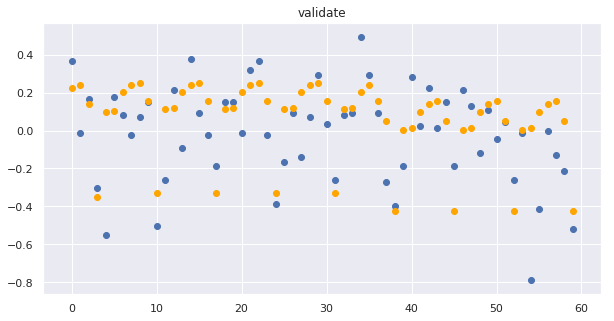

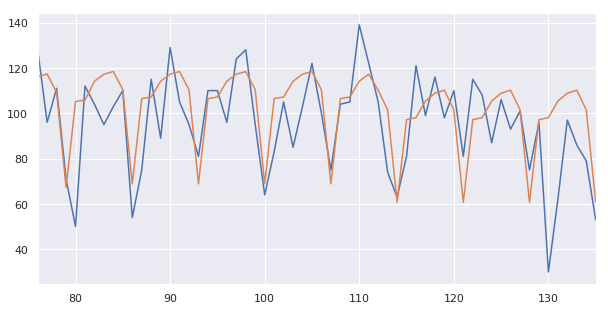

In [1643]:
window = 60
plt.scatter(range(len(valid_target[-window:])),valid_target[-window:],c='b')
plt.scatter(range(len(results[-window:])),results[-window:],c='orange')
plt.title('validate')
plt.show()
compara2['real'][len(compara2)-window:].plot()
compara2['prediccion'][len(compara2)-window:].plot()

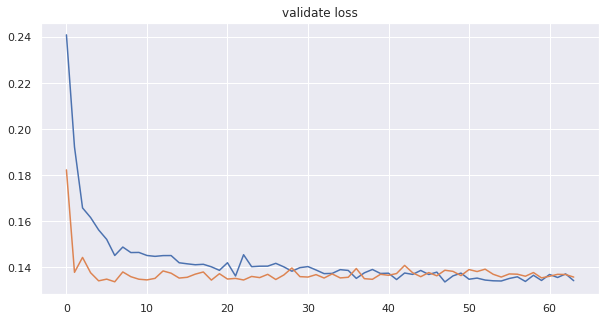

In [1644]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

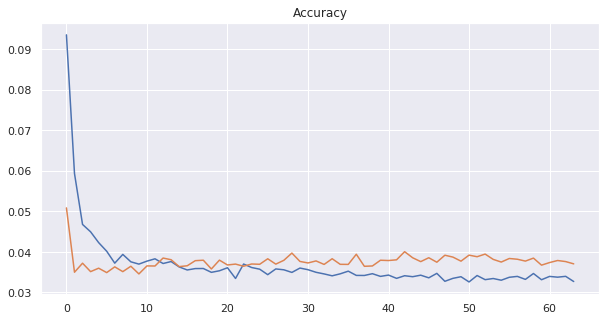

In [1645]:
plt.title('Accuracy')
plt.plot(history.history['mse'])

plt.plot(history.history['val_mse'])
plt.show()